# Audio Feature Extraction

In [1]:
import librosa
from glob import glob
import sys
import os

sys.path.append(os.path.abspath("../"))


In [2]:
from src.utils import env

audio_files = glob(os.path.join(env["DATASET_PATH"], "spotify_sample", "**", "*.mp3"), recursive=True)
len(audio_files)

157445

In [3]:
audio_files[0]

'/data1/meta_midi_dataset/spotify_sample/6/5/y/65yDyFGWY1nAAEIoPoGSL6.mp3'

## Audio Feature Database Table Architecture

```sql
CREATE TABLE Audio_Features (
    spotidy_track_id TEXT REFERENCES Song(spotidy_track_id),
    tempo FLOAT,
    zero_crossing_rate FLOAT,
    percussive_components FLOAT,
    harmonic_components FLOAT,
    spectral_centroid FLOAT,
    spectral_rolloff FLOAT,
    mfcc FLOAT,
    chroma_frequencies FLOAT,
);
```


In [4]:
from random import choice

y, sr = librosa.load(choice(audio_files))
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


661248
Sampling rate (Hz): 22050
Audio length (seconds): 29.99


In [6]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

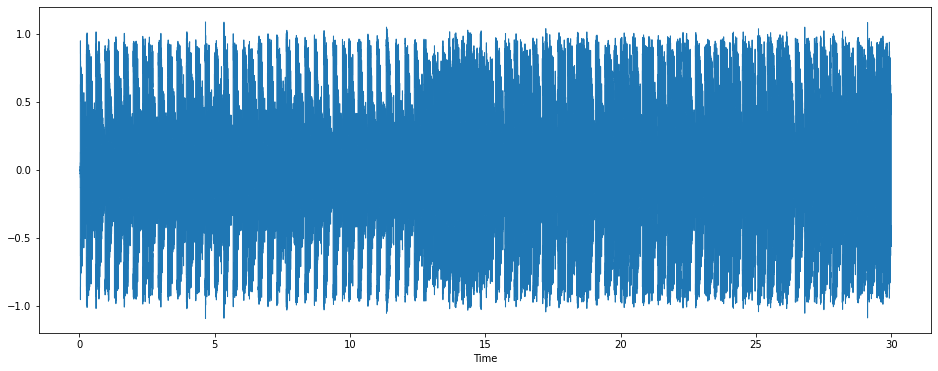

In [7]:
import matplotlib.pyplot as plt
from  librosa.display import waveshow

plt.figure(figsize=(16,6))
waveshow(y=y, sr=sr)

(1025, 1292)


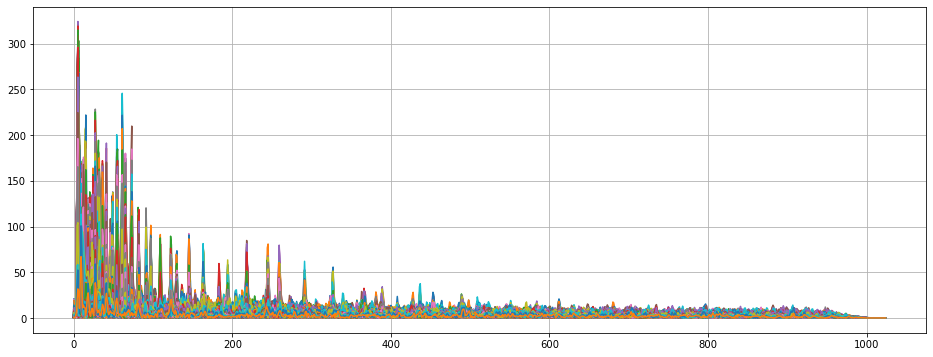

In [8]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.grid()
plt.show()

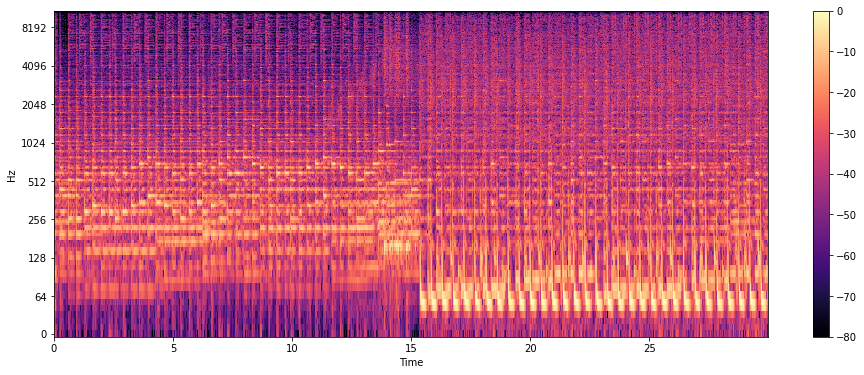

In [9]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Extract Features

In [36]:
from sklearn.preprocessing import minmax_scale


def normalize(x, axis=0):
  return minmax_scale(x, axis=axis)


zcr = librosa.feature.zero_crossing_rate(y, pad=False, frame_length=y.shape[0])[0]
y_harm, y_perc = librosa.effects.hpss(y)
rms = librosa.feature.rms(y=y)[0]
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
mfccs = normalize(librosa.feature.mfcc(y=y, sr=sr), axis=1)
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

print("signal:" , y.shape)
print("zcr:" , zcr.shape)
print("rms:" , rms.shape)
print("y_harm:" , y_harm.shape)
print("y_perc:" , y_perc.shape)
print("spectral_centroids:" , spectral_centroids.shape)
print("spectral_rolloff:" , spectral_rolloff.shape)
print("mfccs:" , mfccs.shape)
print("chromagram:" , chromagram.shape)


signal: (661248,)
zcr: (1292,)
rms: (1292,)
y_harm: (661248,)
y_perc: (661248,)
spectral_centroids: (1292,)
spectral_rolloff: (1292,)
mfccs: (20, 1292)
chromagram: (12, 1292)


In [32]:
librosa.feature.rms(y=y).shape

(1, 1292)

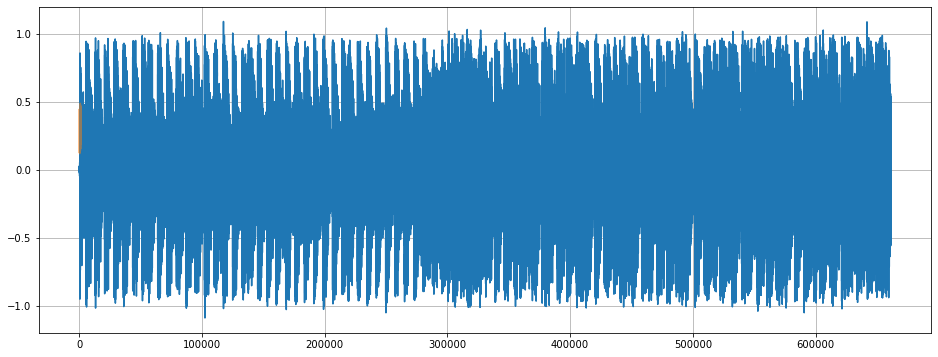

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(y)

plt.grid()
plt.show()

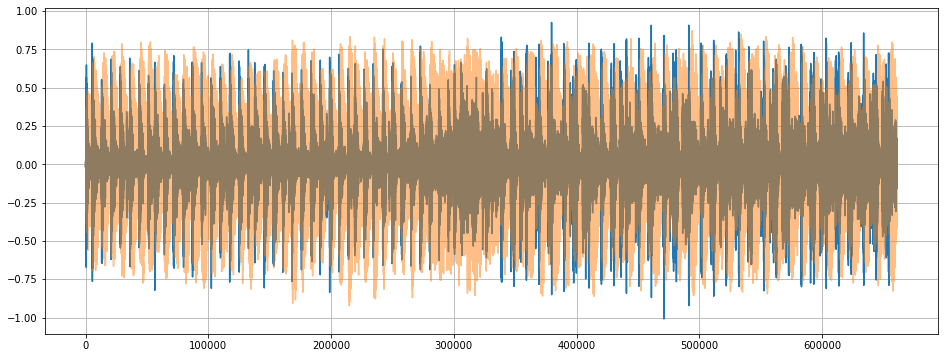

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(y_perc)
plt.plot(y_harm, alpha=0.5)
plt.grid()
plt.show()

/tmp/ipykernel_3870/1672461221.py:2: FutureWarning: Pass y=[-0.01154553 -0.01711104 -0.01793631 ... -0.0136973  -0.05677537
  0.01773094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  plt.plot(librosa.feature.rms(y_perc)[0])
/tmp/ipykernel_3870/1672461221.py:3: FutureWarning: Pass y=[ 0.01154552  0.01711104  0.01793631 ...  0.0046715  -0.01875804
  0.09789052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  plt.plot(librosa.feature.rms(y_harm)[0])


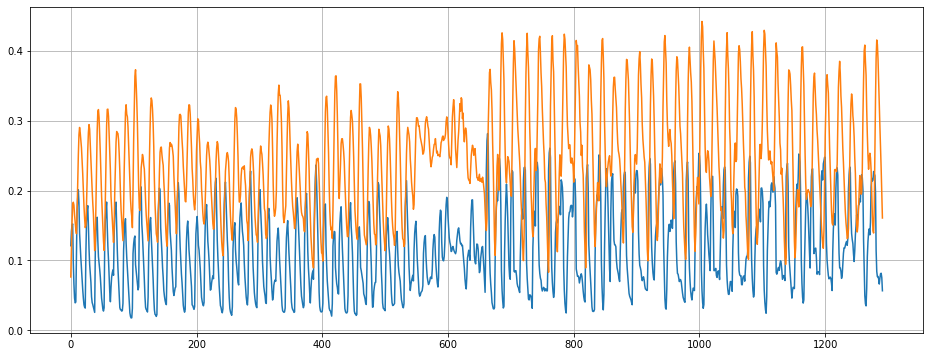

In [42]:
plt.figure(figsize=(16, 6))
plt.plot(librosa.feature.rms(y_perc)[0])
plt.plot(librosa.feature.rms(y_harm)[0])
plt.grid()
plt.show()

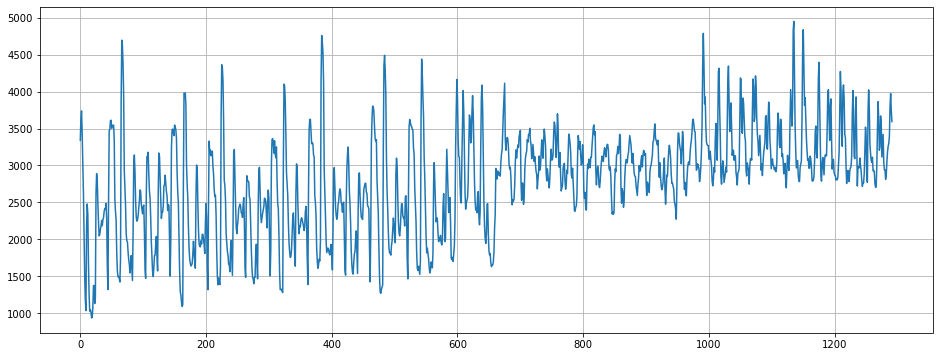

In [44]:
plt.figure(figsize=(16, 6))
plt.plot(spectral_centroids)
plt.grid()
plt.show()

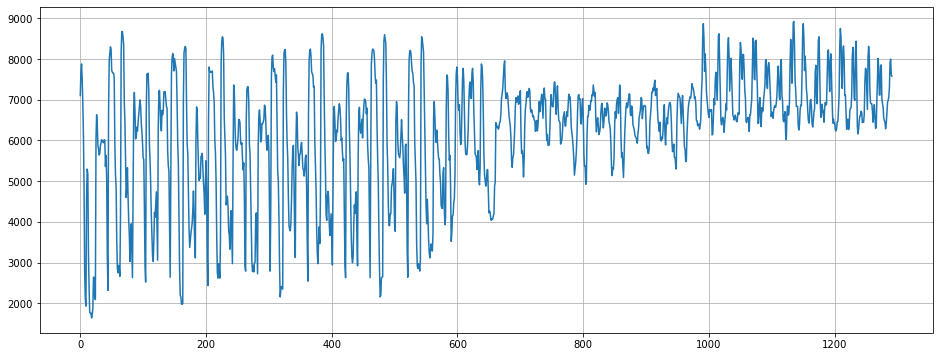

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(spectral_rolloff)
plt.grid()
plt.show()

In [52]:
chromagram.shape

(12, 1292)

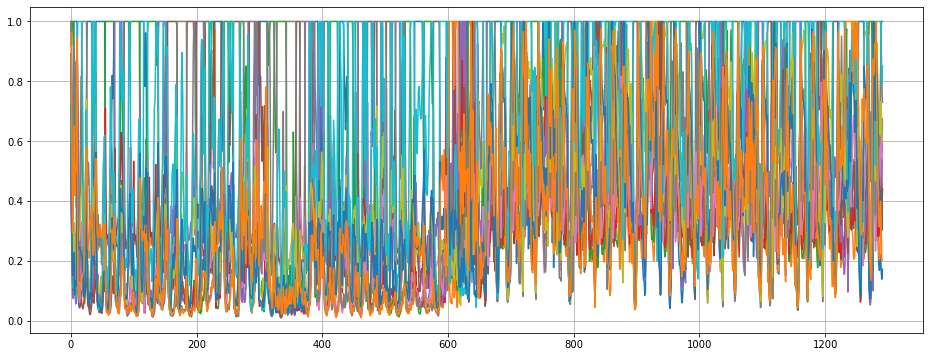

In [53]:
plt.figure(figsize=(16, 6))
for i in range(12):
    plt.plot(chromagram[i])
plt.grid()
plt.show()

In [66]:
chromagram.mean(axis=1).shape

(12,)

<BarContainer object of 12 artists>

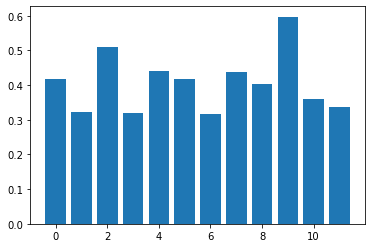

In [57]:
plt.bar(range(12), chromagram.mean(axis=1))

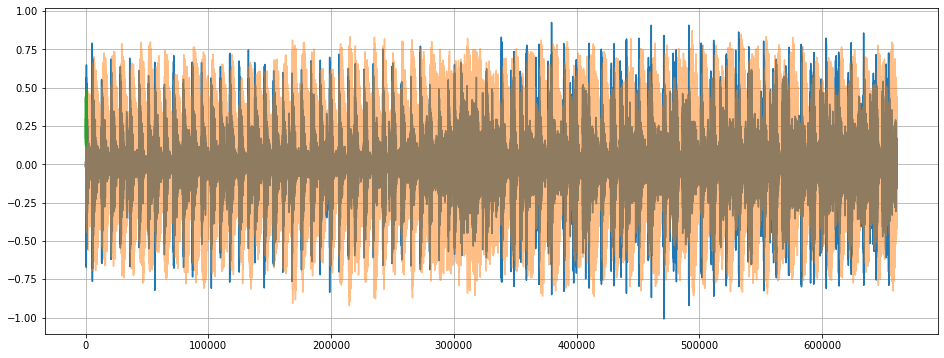

In [45]:
plt.figure(figsize=(16, 6))
plt.plot(y_perc)
plt.plot(y_harm, alpha=0.5)
plt.plot(rms)
plt.grid()
plt.show()

In [65]:
from typing import List

def average_in_n_block(d: np.ndarray, n=5) -> List[float]:
    l: List[np.ndarray] = np.array_split(y, 5)
    ave = [ll.mean() for ll in l]
    return ave

average_in_n_block(rms, 5)

[-0.00062969216, 0.00031952915, -0.00047255834, -0.00015942677, -0.0008355687]

In [73]:
%%time
from tqdm import tqdm

N = 20
n_blocks = 5

results = []
for path in tqdm(audio_files[:N]):
    spotidy_track_id = path.split(os.path.sep)[-1].replace(".mp3", "")
    y, sr = librosa.load(path)
    tempo = librosa.beat.tempo(y=y,sr=sr)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y, pad=False)[0]
    y_harm, y_perc = librosa.effects.hpss(y=y)
    y_harm_rms = librosa.feature.rms(y=y_harm)[0]
    y_perc_rms = librosa.feature.rms(y=y_perc)[0]
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512).mean(axis=1)
    results.append([
        spotidy_track_id,
        tempo,
        average_in_n_block(zcr, n_blocks),
        average_in_n_block(y_harm_rms, n_blocks),
        average_in_n_block(y_perc_rms, n_blocks),
        average_in_n_block(spectral_centroids, n_blocks),
        average_in_n_block(spectral_rolloff, n_blocks),
        chromagram
    ])

  0%|          | 0/20 [00:00<?, ?it/s]/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
  5%|▌         | 1/20 [00:02<00:42,  2.23s/it]/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 10%|█         | 2/20 [00:04<00:40,  2.25s/it]/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 15%|█▌        | 3/20 [00:06<00:38,  2.26s/it]/home/atsuya/.pyenv/versions/anaconda3-2020.11/envs/album-covers-vqvae/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying aud

CPU times: user 1min 3s, sys: 28.2 s, total: 1min 31s
Wall time: 45.9 s


In [74]:
import pandas as pd

results_df = pd.DataFrame(results, columns=["sid", "tempo", "zcr", "harm", "perc", "spec_cent", "spec_roll", "chroma"])

In [75]:
results_df.head()

,sid,tempo,zcr,harm,perc,spec_cent,spec_roll,chroma
0,65yDyFGWY1nAAEIoPoGSL6,129.199219,"[-0.0014971974, -0.001595991, -0.00093646976, ...","[-0.0014971974, -0.001595991, -0.00093646976, ...","[-0.0014971974, -0.001595991, -0.00093646976, ...","[-0.0014971974, -0.001595991, -0.00093646976, ...","[-0.0014971974, -0.001595991, -0.00093646976, ...","[0.23263034, 0.35839644, 0.29666936, 0.2513699..."
1,65ygse6Fdnez361FitMvHB,123.046875,"[-0.00017077311, 0.0002066989, 0.00033709846, ...","[-0.00017077311, 0.0002066989, 0.00033709846, ...","[-0.00017077311, 0.0002066989, 0.00033709846, ...","[-0.00017077311, 0.0002066989, 0.00033709846, ...","[-0.00017077311, 0.0002066989, 0.00033709846, ...","[0.38160264, 0.4939589, 0.5631019, 0.41350517,..."
2,65yMioAFRtmChAuc8WUFBM,107.666016,"[-0.0001801814, 0.0001604618, 0.000109700726, ...","[-0.0001801814, 0.0001604618, 0.000109700726, ...","[-0.0001801814, 0.0001604618, 0.000109700726, ...","[-0.0001801814, 0.0001604618, 0.000109700726, ...","[-0.0001801814, 0.0001604618, 0.000109700726, ...","[0.23972826, 0.27815074, 0.39936605, 0.3851716..."
3,65yCuO1rnfwmaX69TvlbYl,99.384014,"[-2.6964703e-05, 4.846852e-05, -6.0095495e-05,...","[-2.6964703e-05, 4.846852e-05, -6.0095495e-05,...","[-2.6964703e-05, 4.846852e-05, -6.0095495e-05,...","[-2.6964703e-05, 4.846852e-05, -6.0095495e-05,...","[-2.6964703e-05, 4.846852e-05, -6.0095495e-05,...","[0.28391418, 0.21069986, 0.5065533, 0.28782395..."
4,65ynkEZJeQskFFZRoqmaLp,172.265625,"[0.00054353604, -0.00015068529, 0.00010986808,...","[0.00054353604, -0.00015068529, 0.00010986808,...","[0.00054353604, -0.00015068529, 0.00010986808,...","[0.00054353604, -0.00015068529, 0.00010986808,...","[0.00054353604, -0.00015068529, 0.00010986808,...","[0.20460142, 0.32738602, 0.24397363, 0.2574426..."


## DB Check

In [10]:
import pandas as pd
from sqlalchemy import column, create_engine, text
from src.db import connection_config
from src.utils import AudioFeatureName, create_logger, env
from src.audio_feature import sid_to_filepath, is_downloaded

In [8]:
if connection_config["host"]:
    engine = create_engine(
        "postgresql://{user}:{password}@{host}/{database}".format(
            **connection_config), echo=True)
else:
    engine = create_engine(
        "postgresql://{user}:{password}@/{database}?host={socket}".format(
            **connection_config), echo=True)
q = text("SELECT spotify_track_id FROM song;")
res_df = pd.read_sql_query(sql=q, con=engine)
res_df.columns = ["sid"]
audio_files = [sid_to_filepath(sid) for sid in res_df.sid.values]

2022-07-11 23:19:35,345 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2022-07-11 23:19:35,346 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-07-11 23:19:35,347 INFO sqlalchemy.engine.Engine select current_schema()
2022-07-11 23:19:35,348 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-07-11 23:19:35,349 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2022-07-11 23:19:35,350 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-07-11 23:19:35,352 INFO sqlalchemy.engine.Engine SELECT spotify_track_id FROM song;
2022-07-11 23:19:35,352 INFO sqlalchemy.engine.Engine [generated in 0.00074s] {}


In [9]:
audio_files[:5]

['/data1/meta_midi_dataset/spotify_sample/1/8/n/18nz3dlpGFWU4tD8KVnC4L.mp3',
 '/data1/meta_midi_dataset/spotify_sample/6/H/z/6HzxrWLUp8dM2plZT3Bd6v.mp3',
 '/data1/meta_midi_dataset/spotify_sample/4/L/p/4LpXbyJANnWTRDq1PDsN5x.mp3',
 '/data1/meta_midi_dataset/spotify_sample/6/i/q/6iqiIgyjlWgZyejdjLcsq5.mp3',
 '/data1/meta_midi_dataset/spotify_sample/0/5/R/05RBshrjlH6FW0fSv9SNZb.mp3']

In [17]:
cnts = [is_downloaded(p) for p in audio_files]

cnts.count(True)

0

In [16]:
from src.audio_feature import all_audio_files

all_audio_files[:5]

cnts = [is_downloaded(p) for p in all_audio_files]

cnts.count(True)

0

In [14]:
from src.datasets import MMD_audio_matches

MMD_audio_matches.head(5)

2022-07-11 23:34:05,266 - datasets.py - INFO - Loading MMD_audio_matched_genre data
2022-07-11 23:34:05,648 - datasets.py - INFO - Loading MMD_md5_metainfo data
2022-07-11 23:34:05,816 - datasets.py - INFO - Loading MMD_audio_matches data


,md5,score,sid
0,977349d0bec3fed4bd2bef1b57c597d4,0.554720,5n3es2C6R47r4WGfmYL9vZ
1,a8ab220d3e771f14994bcb6104a6e733,0.910470,65yDyFGWY1nAAEIoPoGSL6
2,a8ab220d3e771f14994bcb6104a6e733,0.743186,6WRwxMiwig6czraGVt3xEB
3,a8ab220d3e771f14994bcb6104a6e733,0.775063,6X72YoEcN8Iuw4e70NMb1V
4,a8ab220d3e771f14994bcb6104a6e733,0.675244,1Yg4ZDCR9z6AEHwEuWqNAe
